# Question 3

# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from keras.layers import Input, Dense, Activation
from keras.models import Model
from keras.datasets import mnist
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from keras.callbacks import LearningRateScheduler

2023-11-09 11:29:51.424292: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 11:29:51.456578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 11:29:51.457166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 11:29:52.500840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

In [4]:
X_train_normalized = X_train_flatten.astype('float32') / 255.
X_test_normalized = X_test_flatten.astype('float32') / 255.

Since calculations of finding mask for all train data might be too much time consuming, we select smaller piece of train data to train the network.

In [5]:
X_train_subset, _, Y_train_subset, _ = train_test_split(X_train_normalized, Y_train,
                                                        train_size=1000, stratify=Y_train, random_state=53)

In [6]:
X_train_subset.shape

(1000, 784)

In [7]:
input_size = X_train_subset.shape[1]

#encoder:
encoder_input = Input(shape=(input_size,))
encoder_hidden1 = Dense(512, activation='relu')(encoder_input)
encoder_hidden2 = Activation(activation='tanh')(encoder_hidden1)
encoder_hidden3 = Dense(128, activation='relu')(encoder_hidden2)
encoder_hidden4 = Activation(activation='tanh')(encoder_hidden3)
encoder_hidden5 = Dense(32, activation='tanh')(encoder_hidden4)
encoder_output = Dense(10, activation='linear')(encoder_hidden5) # also decoder input
#decoder:
decoder_hidden1 = Dense(32, activation='tanh')(encoder_output)
decoder_hidden2 = Dense(128, activation='tanh')(decoder_hidden1)
decoder_hidden3 = Dense(512, activation='tanh')(decoder_hidden2)
decoder_output = Dense(784, activation='sigmoid')(decoder_hidden3)



2023-11-09 11:30:16.576801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-11-09 11:30:16.576825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: Javad-Bshrt
2023-11-09 11:30:16.576829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: Javad-Bshrt
2023-11-09 11:30:16.576908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.129.3
2023-11-09 11:30:16.576924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.129.3
2023-11-09 11:30:16.576928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.129.3


In [8]:
autoencoder = Model(encoder_input, decoder_output)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 10)                330   

Let's see how many classes exist in MNIST dataset.

In [9]:
np.unique(Y_train_subset)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [10]:
features_count = X_train_subset.shape[1]
samples_count = X_train_subset.shape[0]


In [11]:
def find_same_labels():
    same_labels_inds = {}

    for i in range(10):
        same_labels_inds[i] = np.where(Y_train_subset == i)[0]

    return same_labels_inds
        

In [12]:
same_labels_inds = find_same_labels()

In [13]:
def calc_inner_ws():

    inner_ws = []

    for i in range(features_count):
        mask_same_labels = 0

        for j in range(10):
            same_label_inds = same_labels_inds[j]
            same_label_inds_count = len(same_label_inds)

            comparisons_count = (same_label_inds_count) * (same_label_inds_count - 1) / 2

            X_train_subset_i = X_train_subset[same_label_inds]

            diff = X_train_subset_i[:, i, None] - X_train_subset_i[:, i, None].T

            exponential_squared_diff_sum = (np.sum(np.exp(-diff ** 2)) - X_train_subset_i.shape[0]) / 2

            mask_same_labels += exponential_squared_diff_sum / comparisons_count

        inner_ws.append(mask_same_labels / 10)

    return np.array(inner_ws)

In [14]:
inner_ws = calc_inner_ws()

In [15]:
def calc_outer_ws():

    outer_ws = []

    for i in range(features_count):
        mask_diff_labels_total = 0

        for j in range(10):
            same_label_inds = same_labels_inds[j]
            same_label_inds_count = len(same_label_inds)

            X_train_subset_i = X_train_subset[same_label_inds]

            mask_diff_labels_partial = 0

            for k in range(10):
                if k != j:
                    variable_label_inds = same_labels_inds[j]
                    variable_label_inds_count = len(variable_label_inds)

                    X_train_subset_j = X_train_subset[variable_label_inds]

                    comparisons_count = same_label_inds_count * variable_label_inds_count

                    diff = X_train_subset_i[:, i, None] - X_train_subset_j[:, i, None].T

                    exponential_squared_diff_sum = np.sum(np.exp(-diff ** 2))

                    mask_diff_labels_partial += (comparisons_count - exponential_squared_diff_sum) / comparisons_count

            mask_diff_labels_total += mask_diff_labels_partial / 9

        outer_ws.append(mask_diff_labels_total / 10)

    return np.array(outer_ws)

In [16]:
outer_ws = calc_outer_ws()

In [17]:
loss_weights = inner_ws * outer_ws

In [18]:
def plot_weights(w):
    weights = w.reshape(28, 28)
    plt.imshow(weights, cmap='gray')
    plt.colorbar
    plt.title('Map of Computed Weights Using 1000 Samples of Data')
    plt.show()

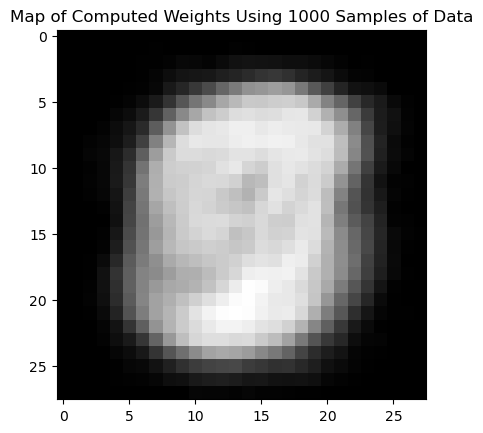

In [19]:
plot_weights(loss_weights)

In [20]:
def custom_loss(y_pred, y_true):
     l1 = np.mean(loss_weights * (y_true - y_pred) ** 2)
     l2_reg = tf.reduce_sum([tf.nn.l2_loss(w) for w in autoencoder.trainable_weights])

     return l1 + 0.00001 * l2_reg


In [21]:
autoencoder_otimizer = Adam(learning_rate=0.003)

autoencoder.compile(optimizer=autoencoder_otimizer, loss=custom_loss)


In [22]:
def lr_scheduler(epoch, lr):
    if epoch <= 10:
        return lr
    else:
        return 0.996 * lr

In [23]:
callback = LearningRateScheduler(lr_scheduler)
autoencoder_history = autoencoder.fit(X_train_normalized, X_train_normalized, epochs=200, callbacks=[callback])

Epoch 1/200


2023-11-09 11:31:12.699337: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-11-09 11:31:12.790294: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 12s 6ms/step - loss: 0.0079 - lr: 0.0030
Epoch 2/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0070 - lr: 0.0030
Epoch 3/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0068 - lr: 0.0030
Epoch 4/200
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0067 - lr: 0.0030
Epoch 5/200
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0066 - lr: 0.0030
Epoch 6/200
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0065 - lr: 0.0030
Epoch 7/200
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0064 - lr: 0.0030
Epoch 8/200
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0064 - lr: 0.0030
Epoch 9/200
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0063 - lr: 0.0030
Epoch 10/200
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0063 - lr: 0.0030
Epoch 11/200
1875/1875 [=======

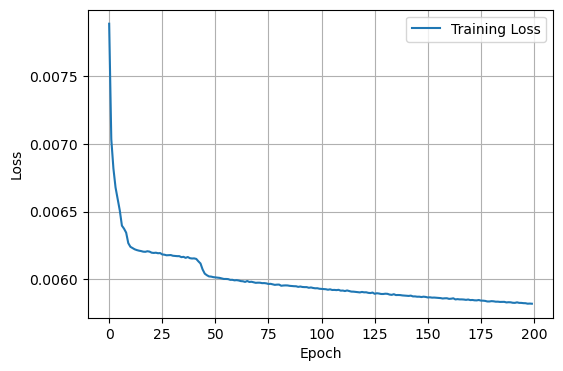

In [24]:
plt.figure(figsize=(6, 4))

plt.plot(autoencoder_history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [28]:
autoencoder_outputs = autoencoder.predict(X_test_normalized)

313/313 [==============================] - 0s 1ms/step


In [29]:
def display_auto_encoder_outputs_vs_test_data():
    samples = []

    for i in range(10):
        # select the first element of each class
        ind = np.where(Y_test == i)[0][0]

        data_image = X_test_normalized[ind]
        data_image = data_image.reshape(28, 28)
        autoencoder_output = autoencoder_outputs[ind]
        autoencoder_output = autoencoder_output.reshape(28, 28)
        label = Y_test[ind]

        samples.append((data_image, autoencoder_output, label))

    _, axes = plt.subplots(2, 10, figsize=(12, 3))

    for i, (data_image, autoencoder_output, label) in enumerate(samples):
        axes[0][i].imshow(data_image, cmap='gray')
        axes[1][i].imshow(autoencoder_output, cmap='gray')

    plt.show()

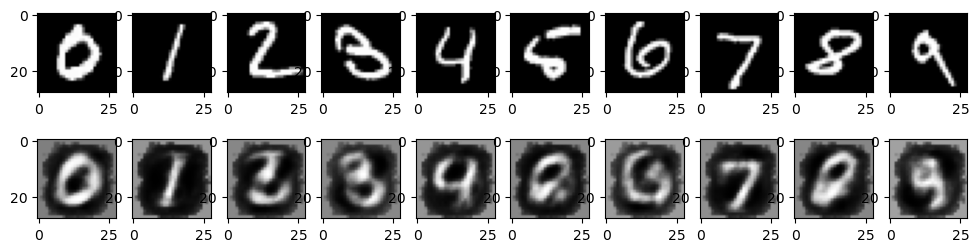

In [30]:
display_auto_encoder_outputs_vs_test_data()

In above plot, you can observe raw test input images on top and their correspond reconstructed images by autoencoder on bottom.

In [31]:
kmeans = KMeans(n_clusters=10)

kmeans.fit(X_test_normalized)

/home/javad/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [32]:
ari_kmeans = adjusted_rand_score(Y_test, kmeans.labels_)

In [33]:
encoder_model = Model(inputs=autoencoder.input, outputs=encoder_output)

encoded_data = encoder_model.predict(X_test_normalized)

313/313 [==============================] - 0s 727us/step


In [34]:
kmeans_DAC = KMeans(n_clusters=10)

kmeans_DAC.fit(encoded_data)

/home/javad/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [35]:
ari_kmeans_DAC = adjusted_rand_score(Y_test, kmeans_DAC.labels_)

In [36]:
print(f'ARI for kmeans: {ari_kmeans}\nARI for DAC: {ari_kmeans_DAC}')

ARI for kmeans: 0.3780363560480308
ARI for DAC: 0.39175889228349203


As expected, knowledge distillation happend again and K-means learnt from encoder part of autoencoder and its performance has been improved!